In [10]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [11]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt


In [12]:
tickerSymbol = 'GOOG'
data = yf.Ticker(tickerSymbol)

In [24]:
prices = data.history(start='2021-12-01', end='2022-05-22').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

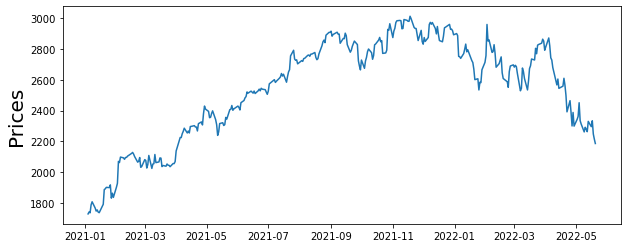

In [14]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

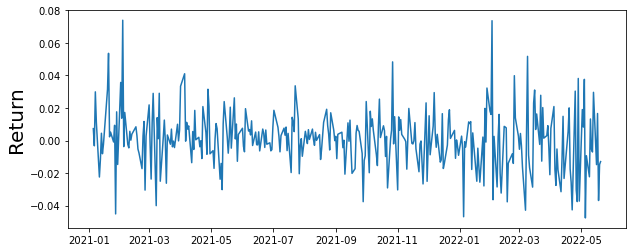

In [15]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

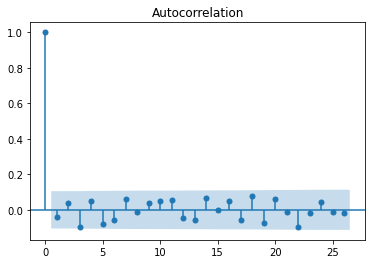

In [16]:
plot_acf(returns)
plt.show()

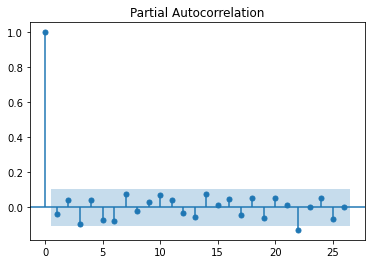

In [17]:
plot_pacf(returns)
plt.show()

100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4537.39it/s]


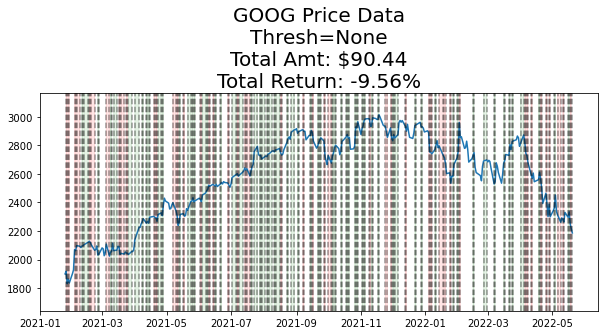

90.4432631744805

In [18]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False) #RANDOM BUYING

In [19]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 6110.01it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 7505.84it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 3418.37it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 1764.68it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 3696.76it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 6432.27it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 5601.53it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4120.34it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4014.19it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4441.29it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 4452.07it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 5026.24it/s]


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 7174.82it/s]


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Avg: $104.97\nSD: $16.95')

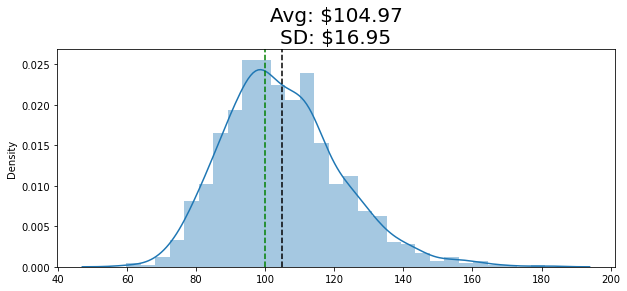

In [20]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)


100%|██████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 3629.27it/s]


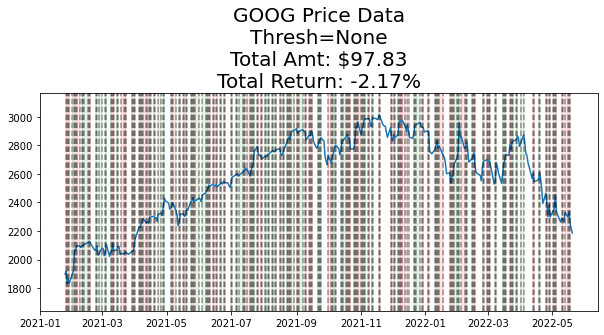

97.83066539574017

In [21]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

  0%|                                                                          | 0/334 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████████████████████████████████████████████████

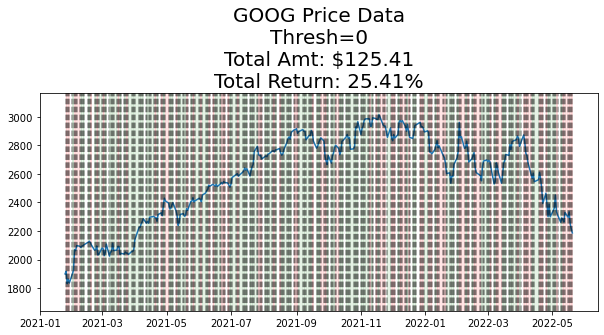

100%|████████████████████████████████████████████████████████████████| 334/334 [00:08<00:00, 38.97it/s]


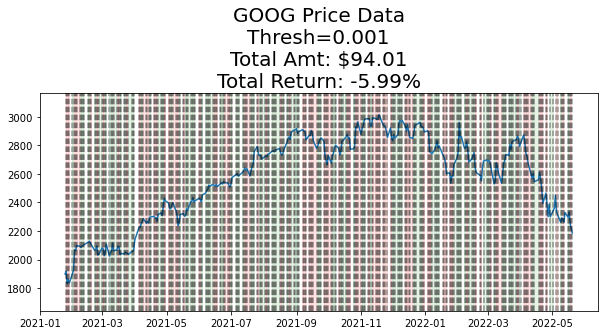

100%|████████████████████████████████████████████████████████████████| 334/334 [00:15<00:00, 21.95it/s]


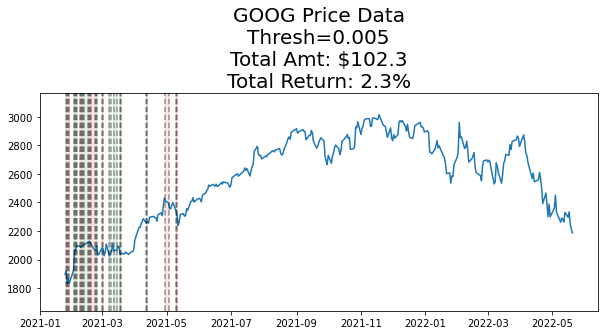

In [22]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

100%|████████████████████████████████████████████████████████████████| 334/334 [01:58<00:00,  2.81it/s]


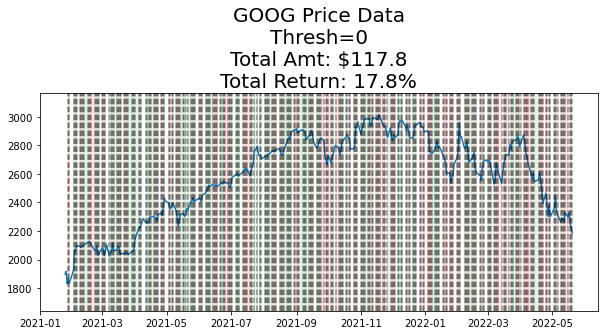

100%|████████████████████████████████████████████████████████████████| 334/334 [01:11<00:00,  4.67it/s]


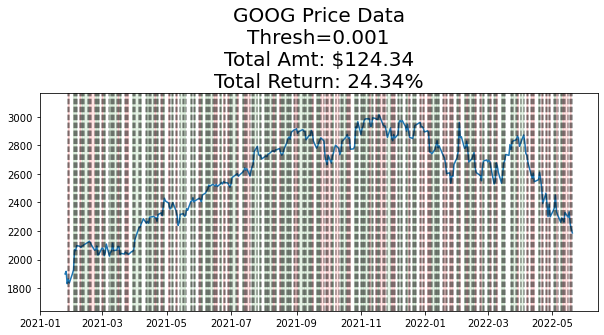

100%|████████████████████████████████████████████████████████████████| 334/334 [01:25<00:00,  3.91it/s]


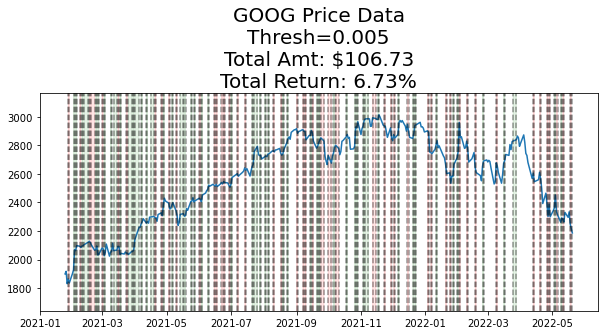

In [23]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\

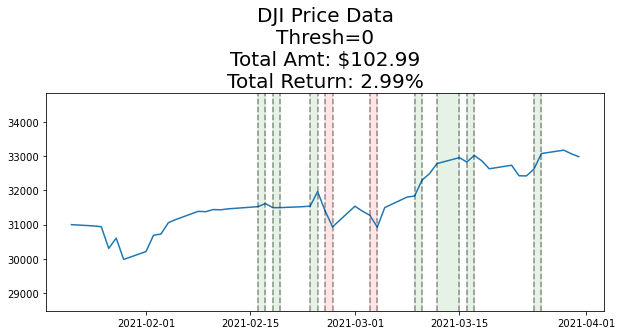

  0%|                                                                                           | 0/47 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\

In [ ]:
#ARMA(5,5)
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)